Notebook to run the WGCNA calling for the functions from the py file. To implement once the method is functioning correctly

In [12]:
### GENERAL CONFIGURATION FOR THE ANALYSIS:
# Imports
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns


sys.path.append(os.getcwd().strip('notebooks') + 'src/')
import WGCNA_functions as wgcnax



# Colors for the terminal outputs
ENDC = "\033[0m"
BOLD = "\033[1m"
UNDERLINE = "\033[4m"

OKBLUE = "\033[94m"
OKGREEN = "\033[92m"
WARNING = "\033[93m"
FAIL = "\033[91m"

# Settings for printing dataframes
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)

# SETTINGS FOR PLOTTING FIGURES
want_plots = True


In [2]:
### LOADING REAL UNPUBLISHED DATA    -     NO PUSHING FOR THE RESULTS

# Move out of the notebook folder to access datasets
working_dir = os.getcwd()
working_dir = working_dir.strip('notebooks')
data_dir = working_dir + 'data/PROTECTED_DATA/BGI_Expression_Data/'



## Load the dataset
# Transcriptomics Data - We assume a dataset structure were col are the genes, and rows are the samples
# transcriptomics_dataset_dir = data_dir + 'CRC.SW.mRNA.symbol.count.csv'  
# transcriptomics_dataset = pd.read_csv(transcriptomics_dataset_dir, index_col=0)

# Transcriptomics Data - We assume a dataset structure were col are the genes, and rows are the samples
transcriptomics_TPM_dataset_dir = data_dir + 'CRC.SW.mRNA.symbol.TPM.csv'  
transcriptomics_dataset = pd.read_csv(transcriptomics_TPM_dataset_dir, index_col=0)

# Sample info and Clinical Traits Data
# Sample info and Clinical Traits Data
sample_info_traits_dir = data_dir + 'Sample_Info_Selection.csv'
trait_dataset = pd.read_csv(sample_info_traits_dir)
trait_dataset


# Figures Saving output dir
figures_dir = working_dir + 'results/testing/'

# Check if the directory exists, and if not, create it
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"{BOLD}{OKBLUE}Creating directory to save results and figures...{ENDC}")


## Make a subset to save RAM
subset_dataset_size = 200
transcriptomics_dataset = transcriptomics_dataset.iloc[:, :subset_dataset_size] 

# RAM usage estimation in GB
RAM_estimate = (subset_dataset_size * subset_dataset_size * 8) / (1024**3)
print(f"The aproximated RAM to analyse this size of dataset is: {RAM_estimate} GB")


The aproximated RAM to analyse this size of dataset is: 0.0002980232238769531 GB


Pre-processing...
simple_preprocess function removed 0 genes
Done...
		The function simple_preprocess ran in 0.00 seconds.
Pre-processing...
preprocess_TPM function removed 7 genes
Done...
		The function preprocess_TPM ran in 0.00 seconds.
Pre-processing...
preprocess_TPM_outlier_deletion function removed 10 genes
Done...
		The function preprocess_TPM_outlier_deletion ran in 2.14 seconds.


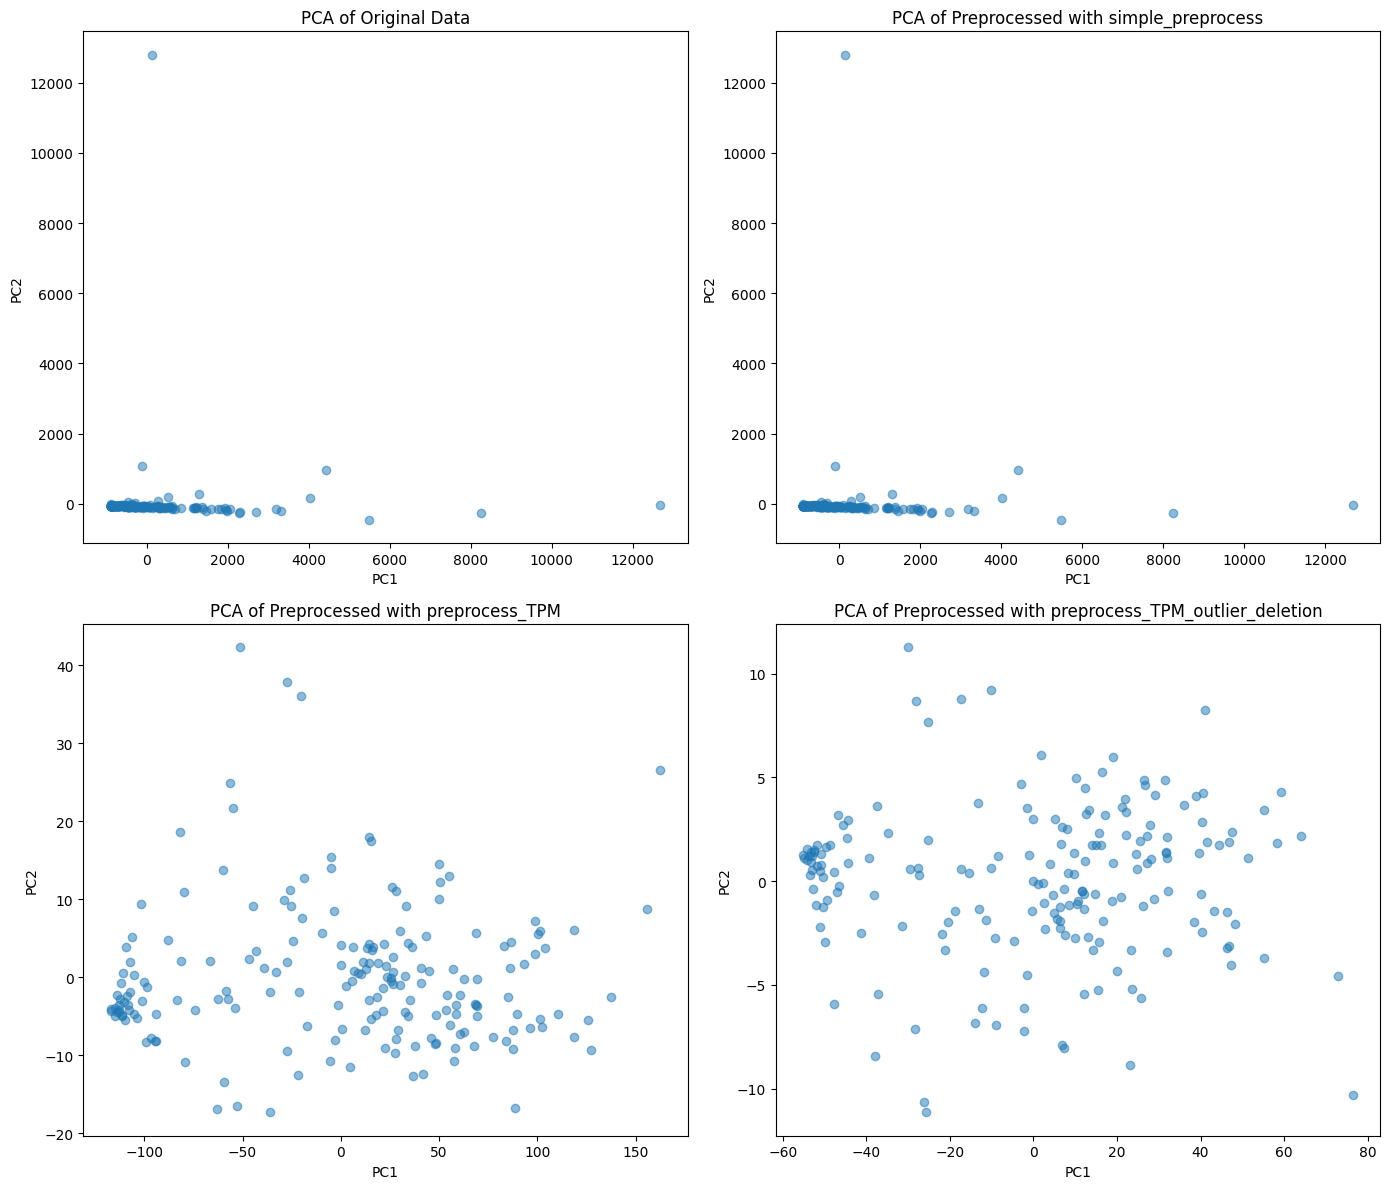

Pre-processing...
preprocess_TPM_outlier_deletion function removed 10 genes
Done...
		The function preprocess_TPM_outlier_deletion ran in 1.68 seconds.
Done...


In [3]:
### Step 1: Data Preprocessing (Normalization)


# Visualize original and preprocessed data with PCA
# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Plot each PCA visualization
expression_th = 1

wgcnax.plot_pca(transcriptomics_dataset, title='PCA of Original Data', ax=axs[0, 0])
wgcnax.plot_pca(wgcnax.simple_preprocess(transcriptomics_dataset), title='PCA of Preprocessed with simple_preprocess', ax=axs[0, 1])
wgcnax.plot_pca(wgcnax.preprocess_TPM(transcriptomics_dataset, expression_th), title='PCA of Preprocessed with preprocess_TPM', ax=axs[1, 0])
wgcnax.plot_pca(wgcnax.preprocess_TPM_outlier_deletion(transcriptomics_dataset, expression_th), title='PCA of Preprocessed with preprocess_TPM_outlier_deletion', ax=axs[1, 1])
plt.tight_layout()
plt.show()




# Pick the preprocessing to actually use:
transcriptomics_dataset_filtered = wgcnax.preprocess_TPM_outlier_deletion(transcriptomics_dataset, expression_th)


print(f"{BOLD}{OKBLUE}Done...{ENDC}")

Calculating Correlation Matrix...
Done...
Plotting and Saving Gene Expression Correlation Matrix Heatmap...


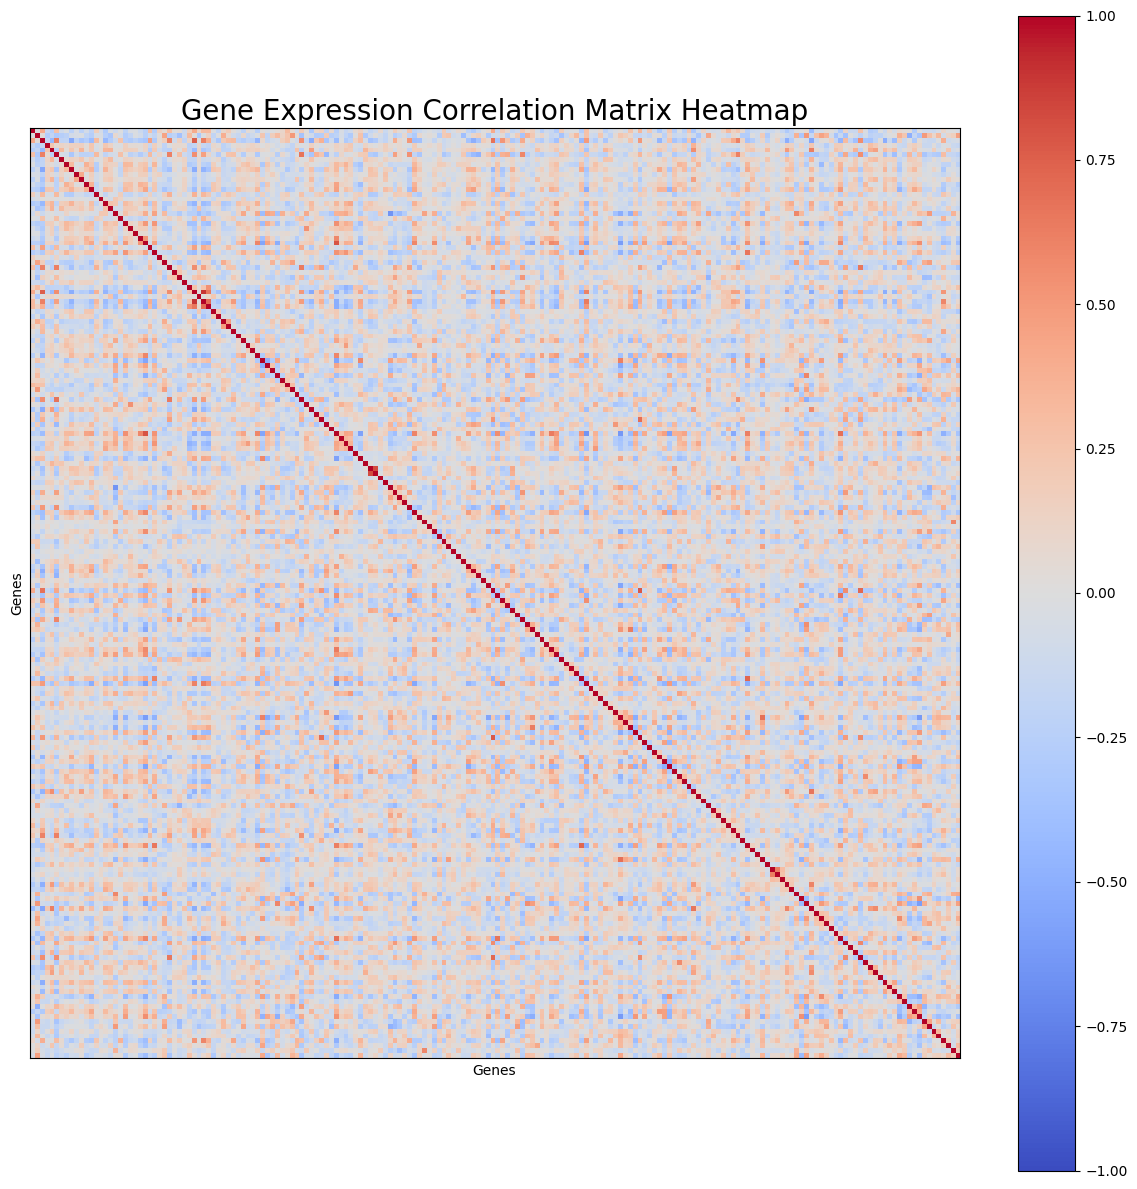

Done
		The function plot_heatmap ran in 0.98 seconds.
		The function correlation_matrix ran in 0.99 seconds.
The matrix satisfies all restrictions.


In [4]:
### Step 2: Constructing a Co-expression Similarity Matrix (Correlation Matrix)

correlation_matrix_np = wgcnax.correlation_matrix(transcriptomics_dataset_filtered, want_plots, figures_dir)

wgcnax.matrix_np_check(correlation_matrix_np, 1, -1, 1)

   Power        R²     Slope  Exponential R² Adjusted  mean(connectivity)  median(connectivity)  max(connectivity)
1      1  0.137362 -0.746770                 0.907922           27.251462          2.665608e+01          49.225464
2      2  0.621198 -1.383207                 0.885824            6.412585          5.685197e+00          18.624201
3      3  0.805563 -1.577427                 0.926084            1.966359          1.473002e+00           8.444022
4      4  0.882518 -1.613556                 0.905912            0.722560          4.547314e-01           4.266048
5      5  0.266545 -2.899310                 0.162514            0.305031          1.521421e-01           2.318585
6      6  0.911563 -1.508386                 0.897195            0.144410          5.862728e-02           1.355098
7      7  0.249270 -2.527232                 0.068503            0.075497          2.569824e-02           0.937428
8      8  0.221007 -2.229168                 0.004450            0.043081       

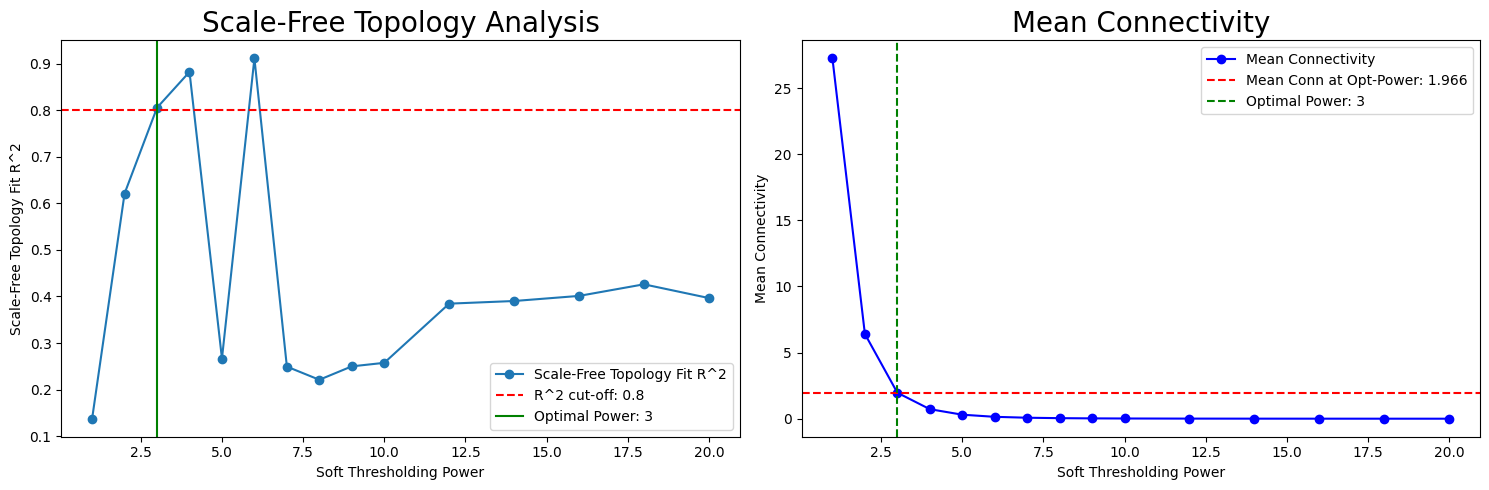

Done

		The function pickSoftThreshold ran in 1.71 seconds.
Calculating Adjacency Matrix...
Done


Plotting and Saving Adjacency Matrix Heatmap...


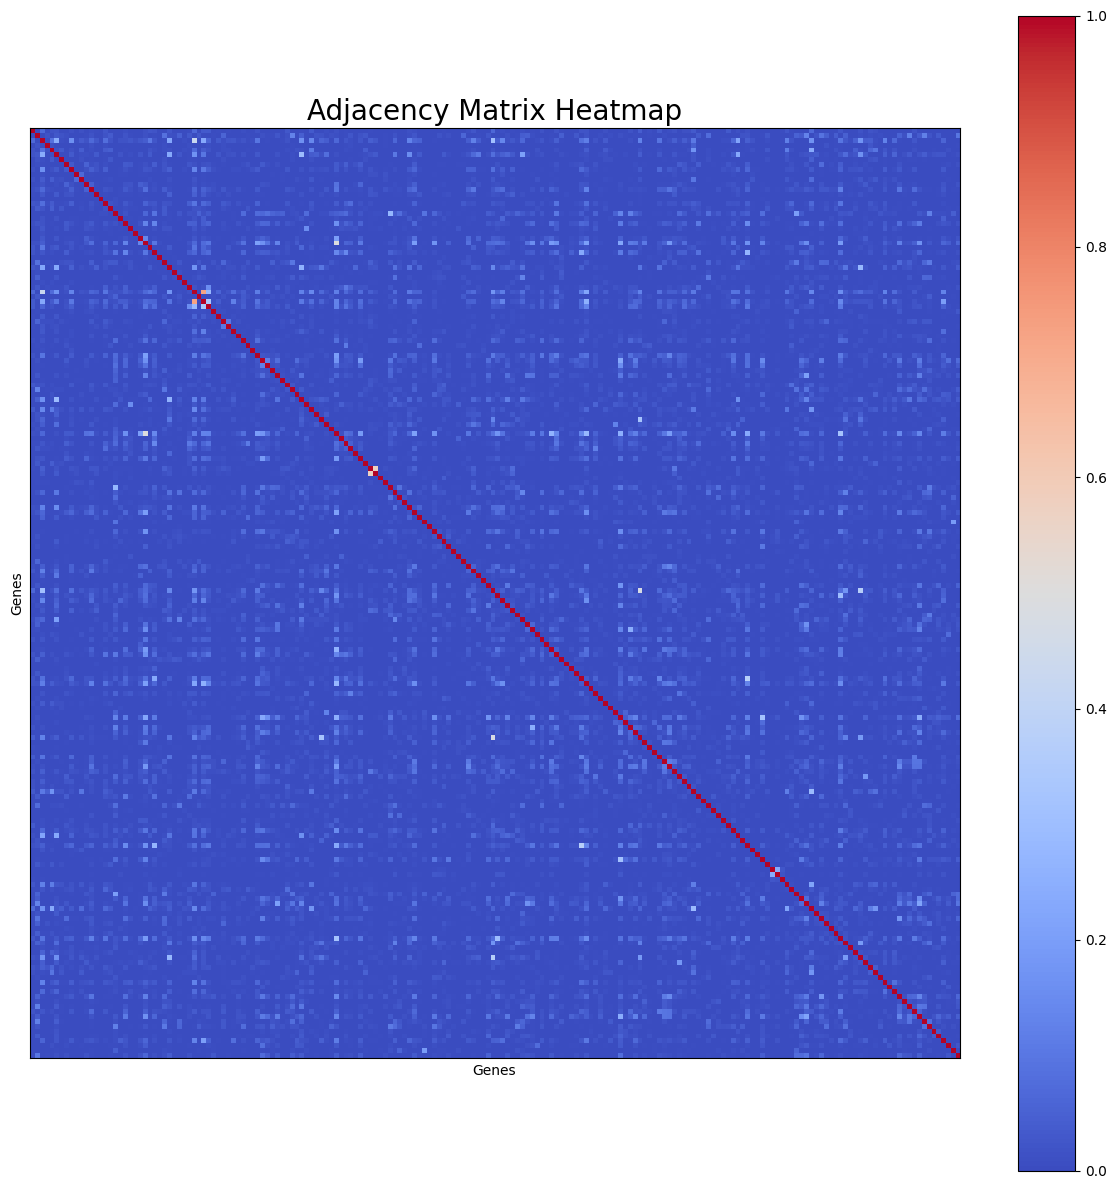

Done
		The function plot_heatmap ran in 0.92 seconds.
		The function adjacencyM_from_correlationM ran in 0.92 seconds.
The matrix satisfies all restrictions.


In [5]:
### Step 3: Transforming into an adjacency matrix using a soft threshold power

## Parameters for execution.
RsquaredCut = 0.8
MeanCut = 100
block_size_scalefit = 10
adjacency_type = "unsigned"


# Get the optimal power for the adjacency matrix (fitting to a power-law distritbution)
optimal_power = wgcnax.pickSoftThreshold(correlation_matrix_np, transcriptomics_dataset_filtered, RsquaredCut, MeanCut, want_plots, figures_dir, block_size_scalefit)

# Get the adjacency matrix
adjacency_matrix_np = wgcnax.adjacencyM_from_correlationM(correlation_matrix_np, optimal_power, adjacency_type, want_plots, figures_dir)
wgcnax.matrix_np_check(adjacency_matrix_np, 1, 0, 1)

Calculating the TOM...
Done...
Plotting and Saving Topological Overlap Matrix (TOM) Heatmap...


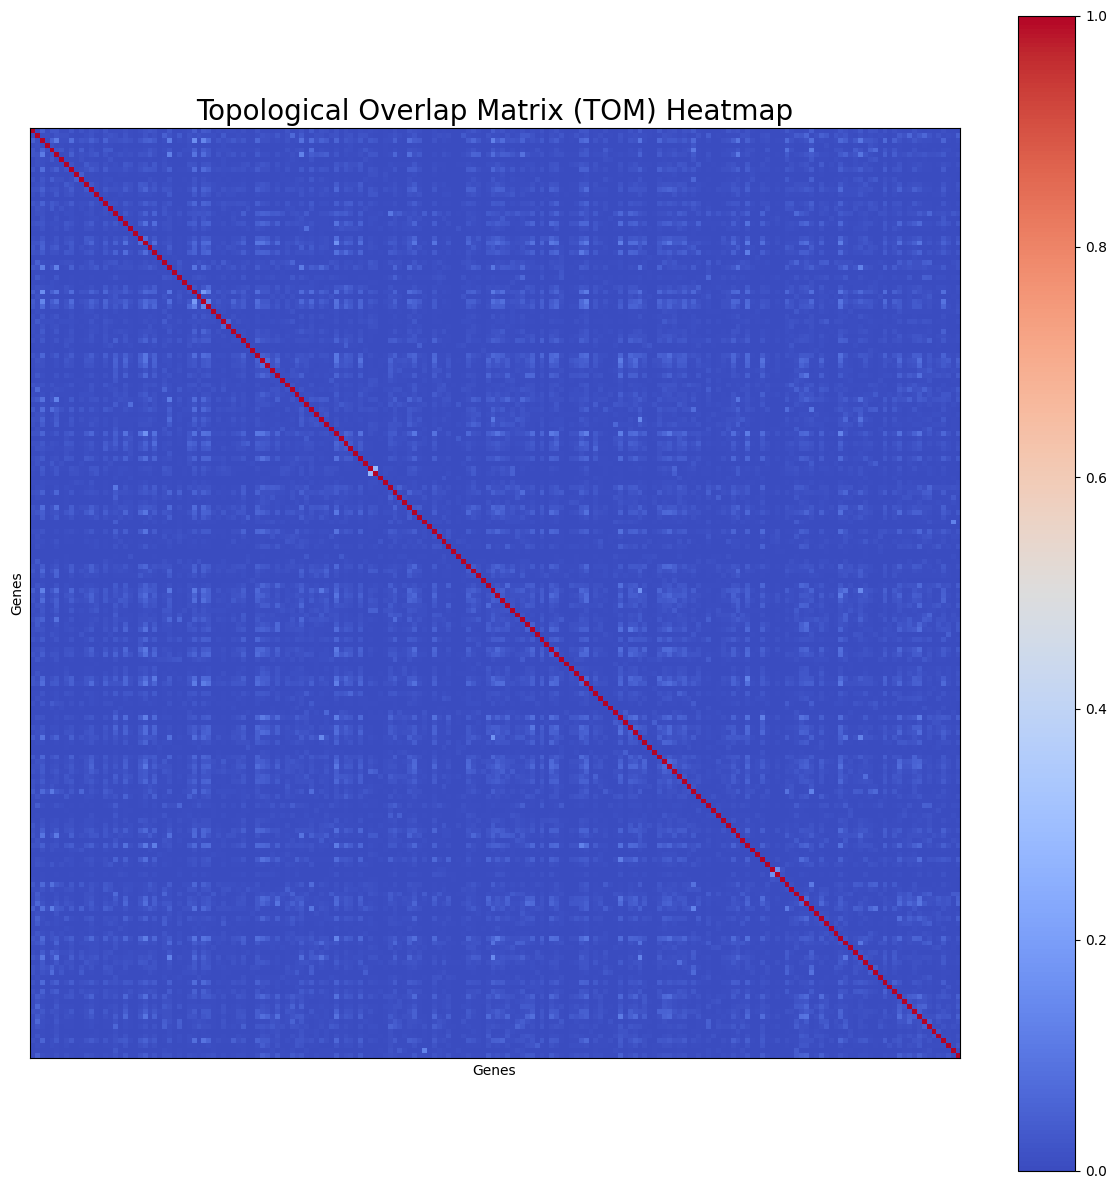

Done
		The function plot_heatmap ran in 1.29 seconds.
		The function calculate_tom ran in 1.30 seconds.
The matrix satisfies all restrictions.


In [6]:
### Step 4: Converting adjacency matrix into a topological overlap matrix (TOM)

# TOMDenom must be either 'min' or 'mean'. More explanation in the function itself
TOMDenom = "mean"

# Get the TOM matrix
simTOM_np = wgcnax.calculate_tom(adjacency_matrix_np, TOMDenom, adjacency_type, want_plots, figures_dir)
dissTOM_np = 1 - simTOM_np
wgcnax.matrix_np_check(simTOM_np, 1, 0, 1)

Doing Hierarchical clustering over the dissimilarity TOM (1-TOM)...
Done...


Plotting and Saving Dendogram from the Hierarchical clustering...


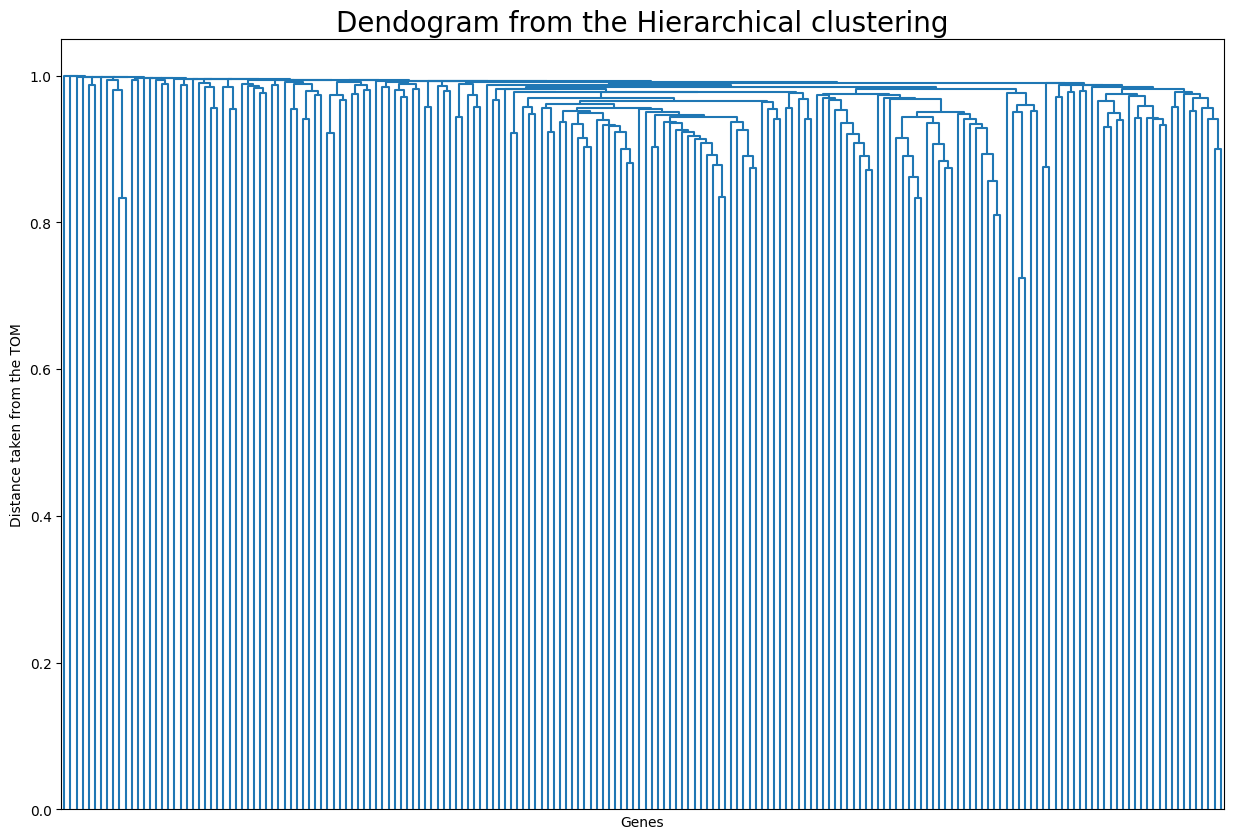

Done
		The function hierarchical_clustering ran in 0.85 seconds.


In [7]:
### Step 5: Hierarchical clustering
linkage_matrix = wgcnax.hierarchical_clustering(dissTOM_np, want_plots, figures_dir)

Finding Modules from the Dendogram with a Tree-Cutting Algorithm...
		The function identify_modules_simple_version ran in 0.02 seconds.


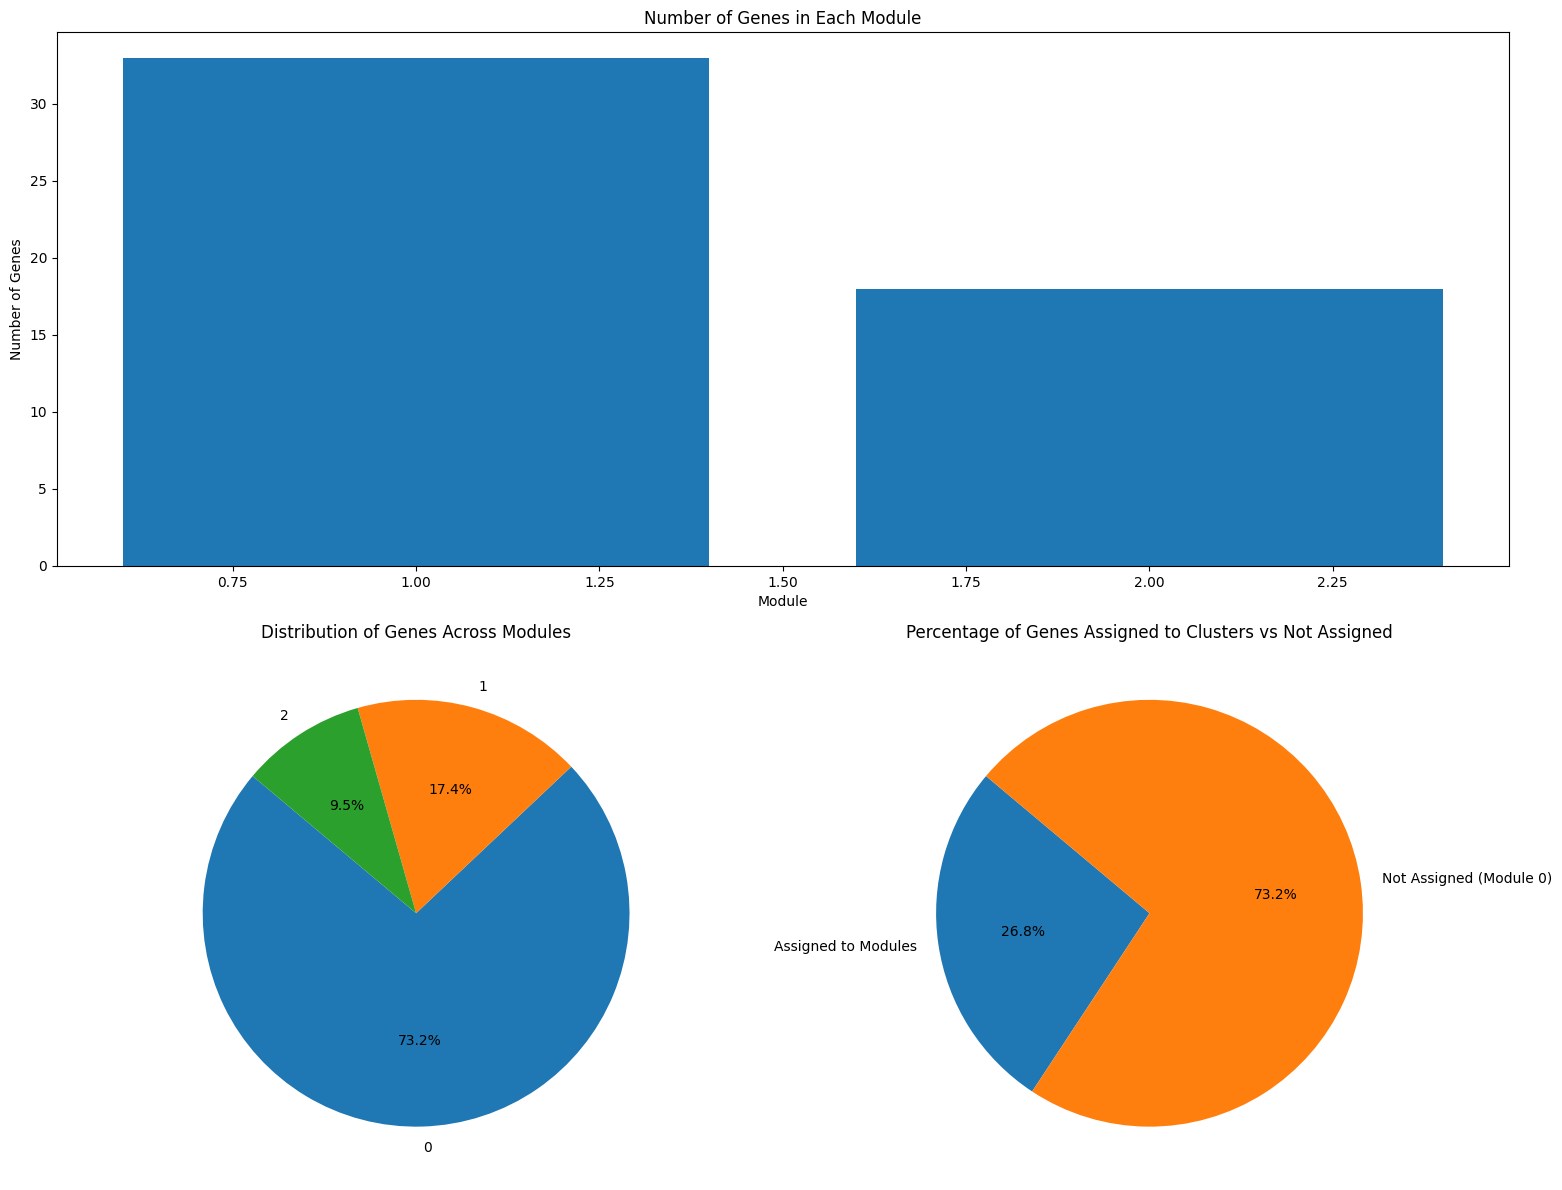

In [8]:
### Step 6: Module identification

#Parameters
min_memb_cluster = 15
height_percentile = 45  # Use the percentile of heights to set sensitivity
module_assignment, cut_height = wgcnax.identify_modules_simple_version(linkage_matrix, height_percentile, min_memb_cluster)

# Add the Gene name to the clustering table
module_assignment.insert(0, 'Gene Name', list(transcriptomics_dataset_filtered))

# Plot visualization of clusters
wgcnax.plot_module_distribution(module_assignment)


		The function find_optimal_cut_height ran in 0.00 seconds.
		The function identify_modules_auto_deep_split ran in 0.16 seconds.


c:\Users\bxz19\anaconda3\envs\WGCNA_approach\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bxz19\anaconda3\envs\WGCNA_approach\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


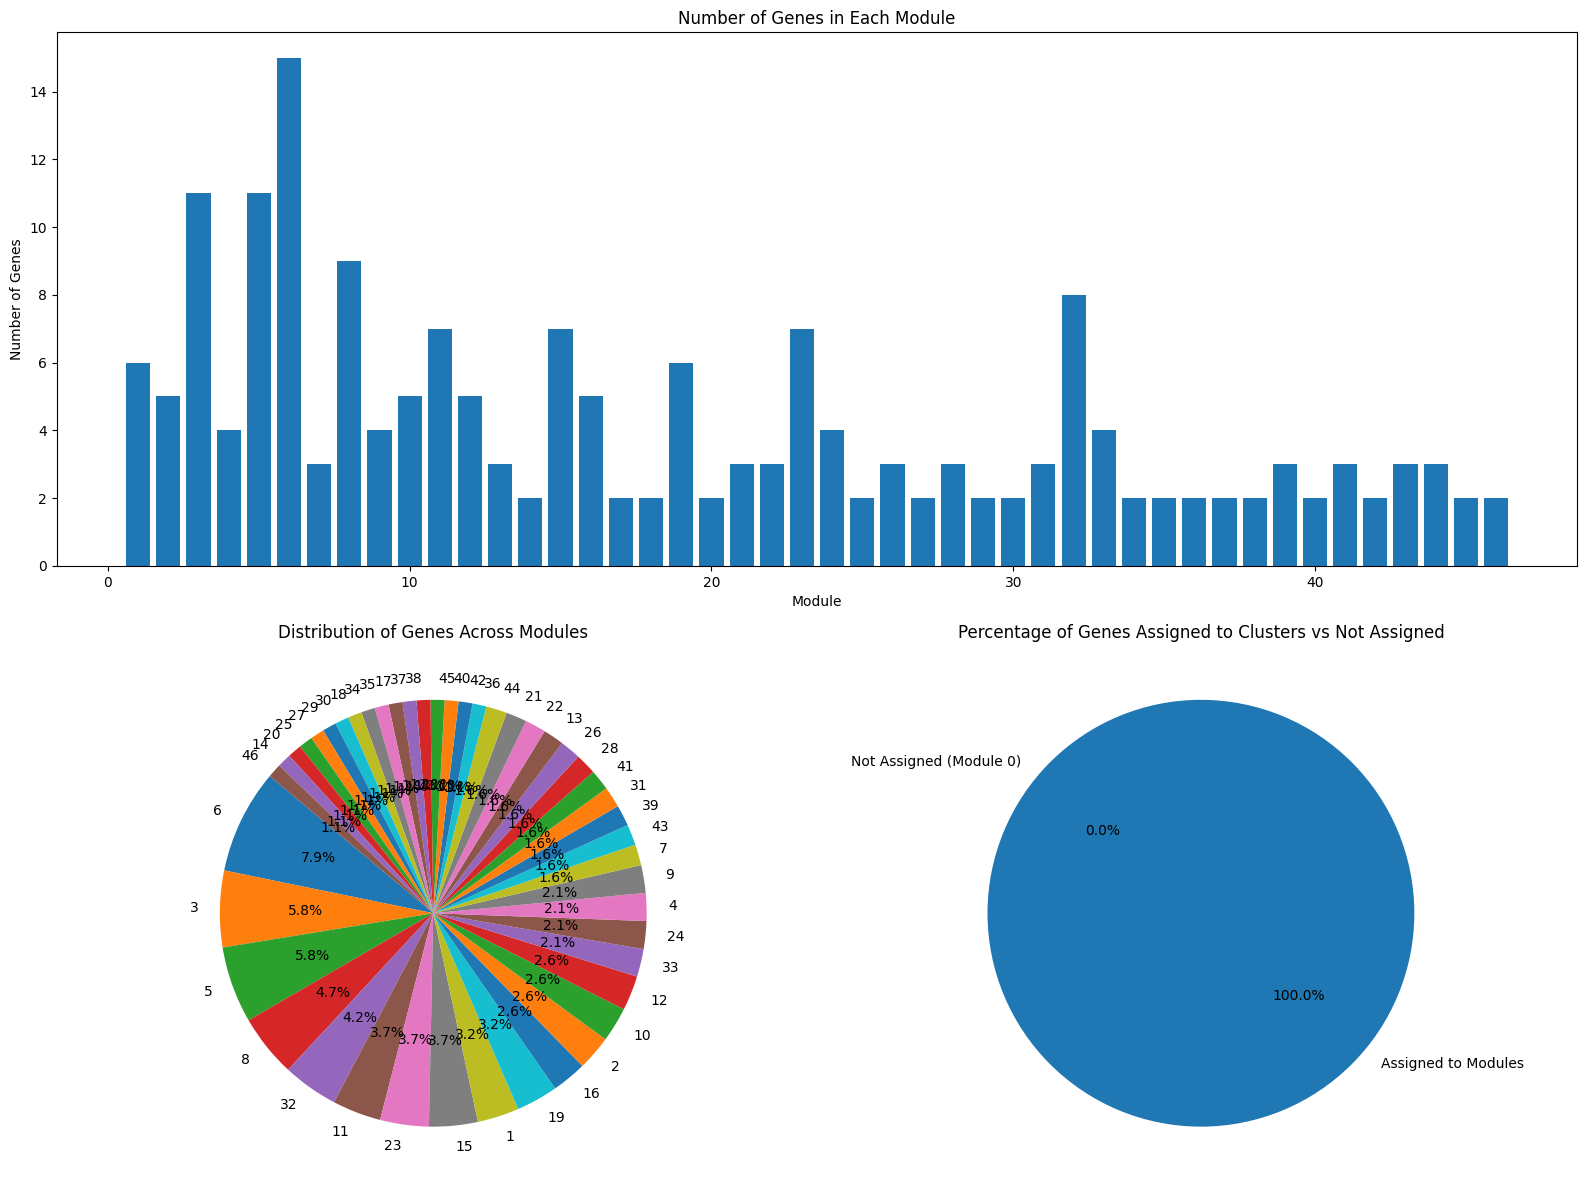

In [9]:
### Step 6: Module identification - SECOND METHOD

module_assignment_sec, cut_height = wgcnax.identify_modules_auto_deep_split(linkage_matrix, dissTOM_np, min_memb_cluster)

# Add the Gene name to the clustering table
module_assignment_sec.insert(0, 'Gene Name', list(transcriptomics_dataset_filtered))

# Plot visualization of clusters
wgcnax.plot_module_distribution(module_assignment_sec)


Calculating EigenGenes...
Done


Plotting and Saving the Eigengene Expression Profile Across Samples...


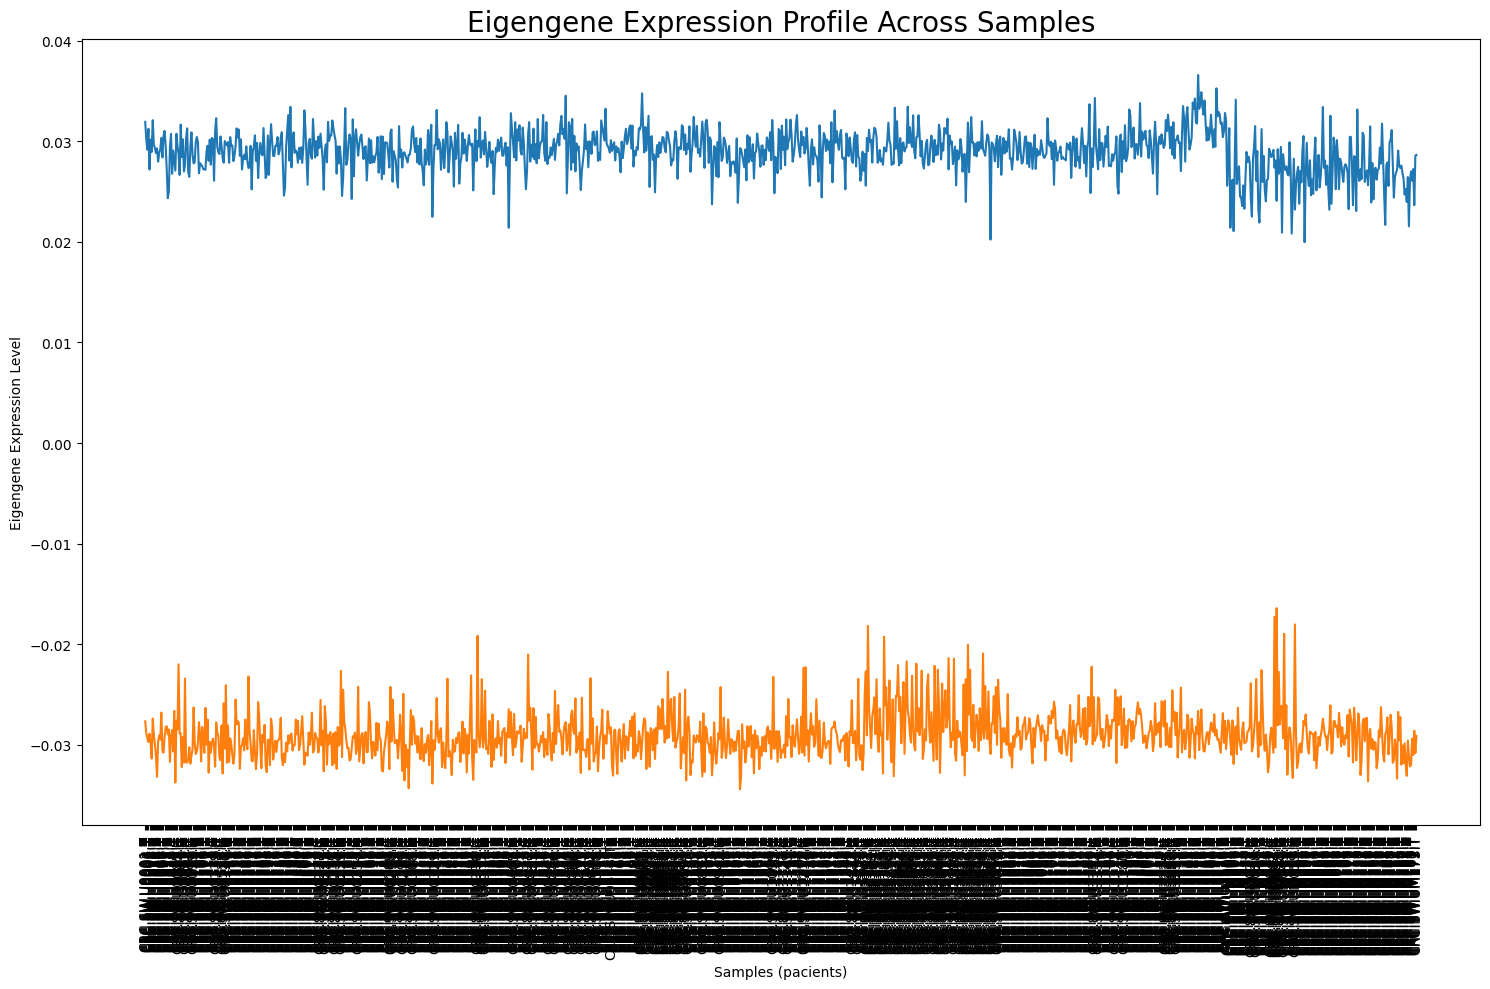

Done
		The function calculate_eigen_genes ran in 16.19 seconds.


In [10]:
### Step 7: Calculate EigenGenes for all identified Modules

## Prepare the dataframe so that it contains all the info we need to continue
expression_profiles = wgcnax.expression_profile_for_cluster(module_assignment, transcriptomics_dataset_filtered)

## Call the function to calculate the eigengenes
eigen_genes = wgcnax.calculate_eigen_genes(expression_profiles, want_plots, figures_dir)

		The function calculate_correlations ran in 0.08 seconds.
Done


Plotting and Saving the Module EigenGene to Clinical Trait Correlation...


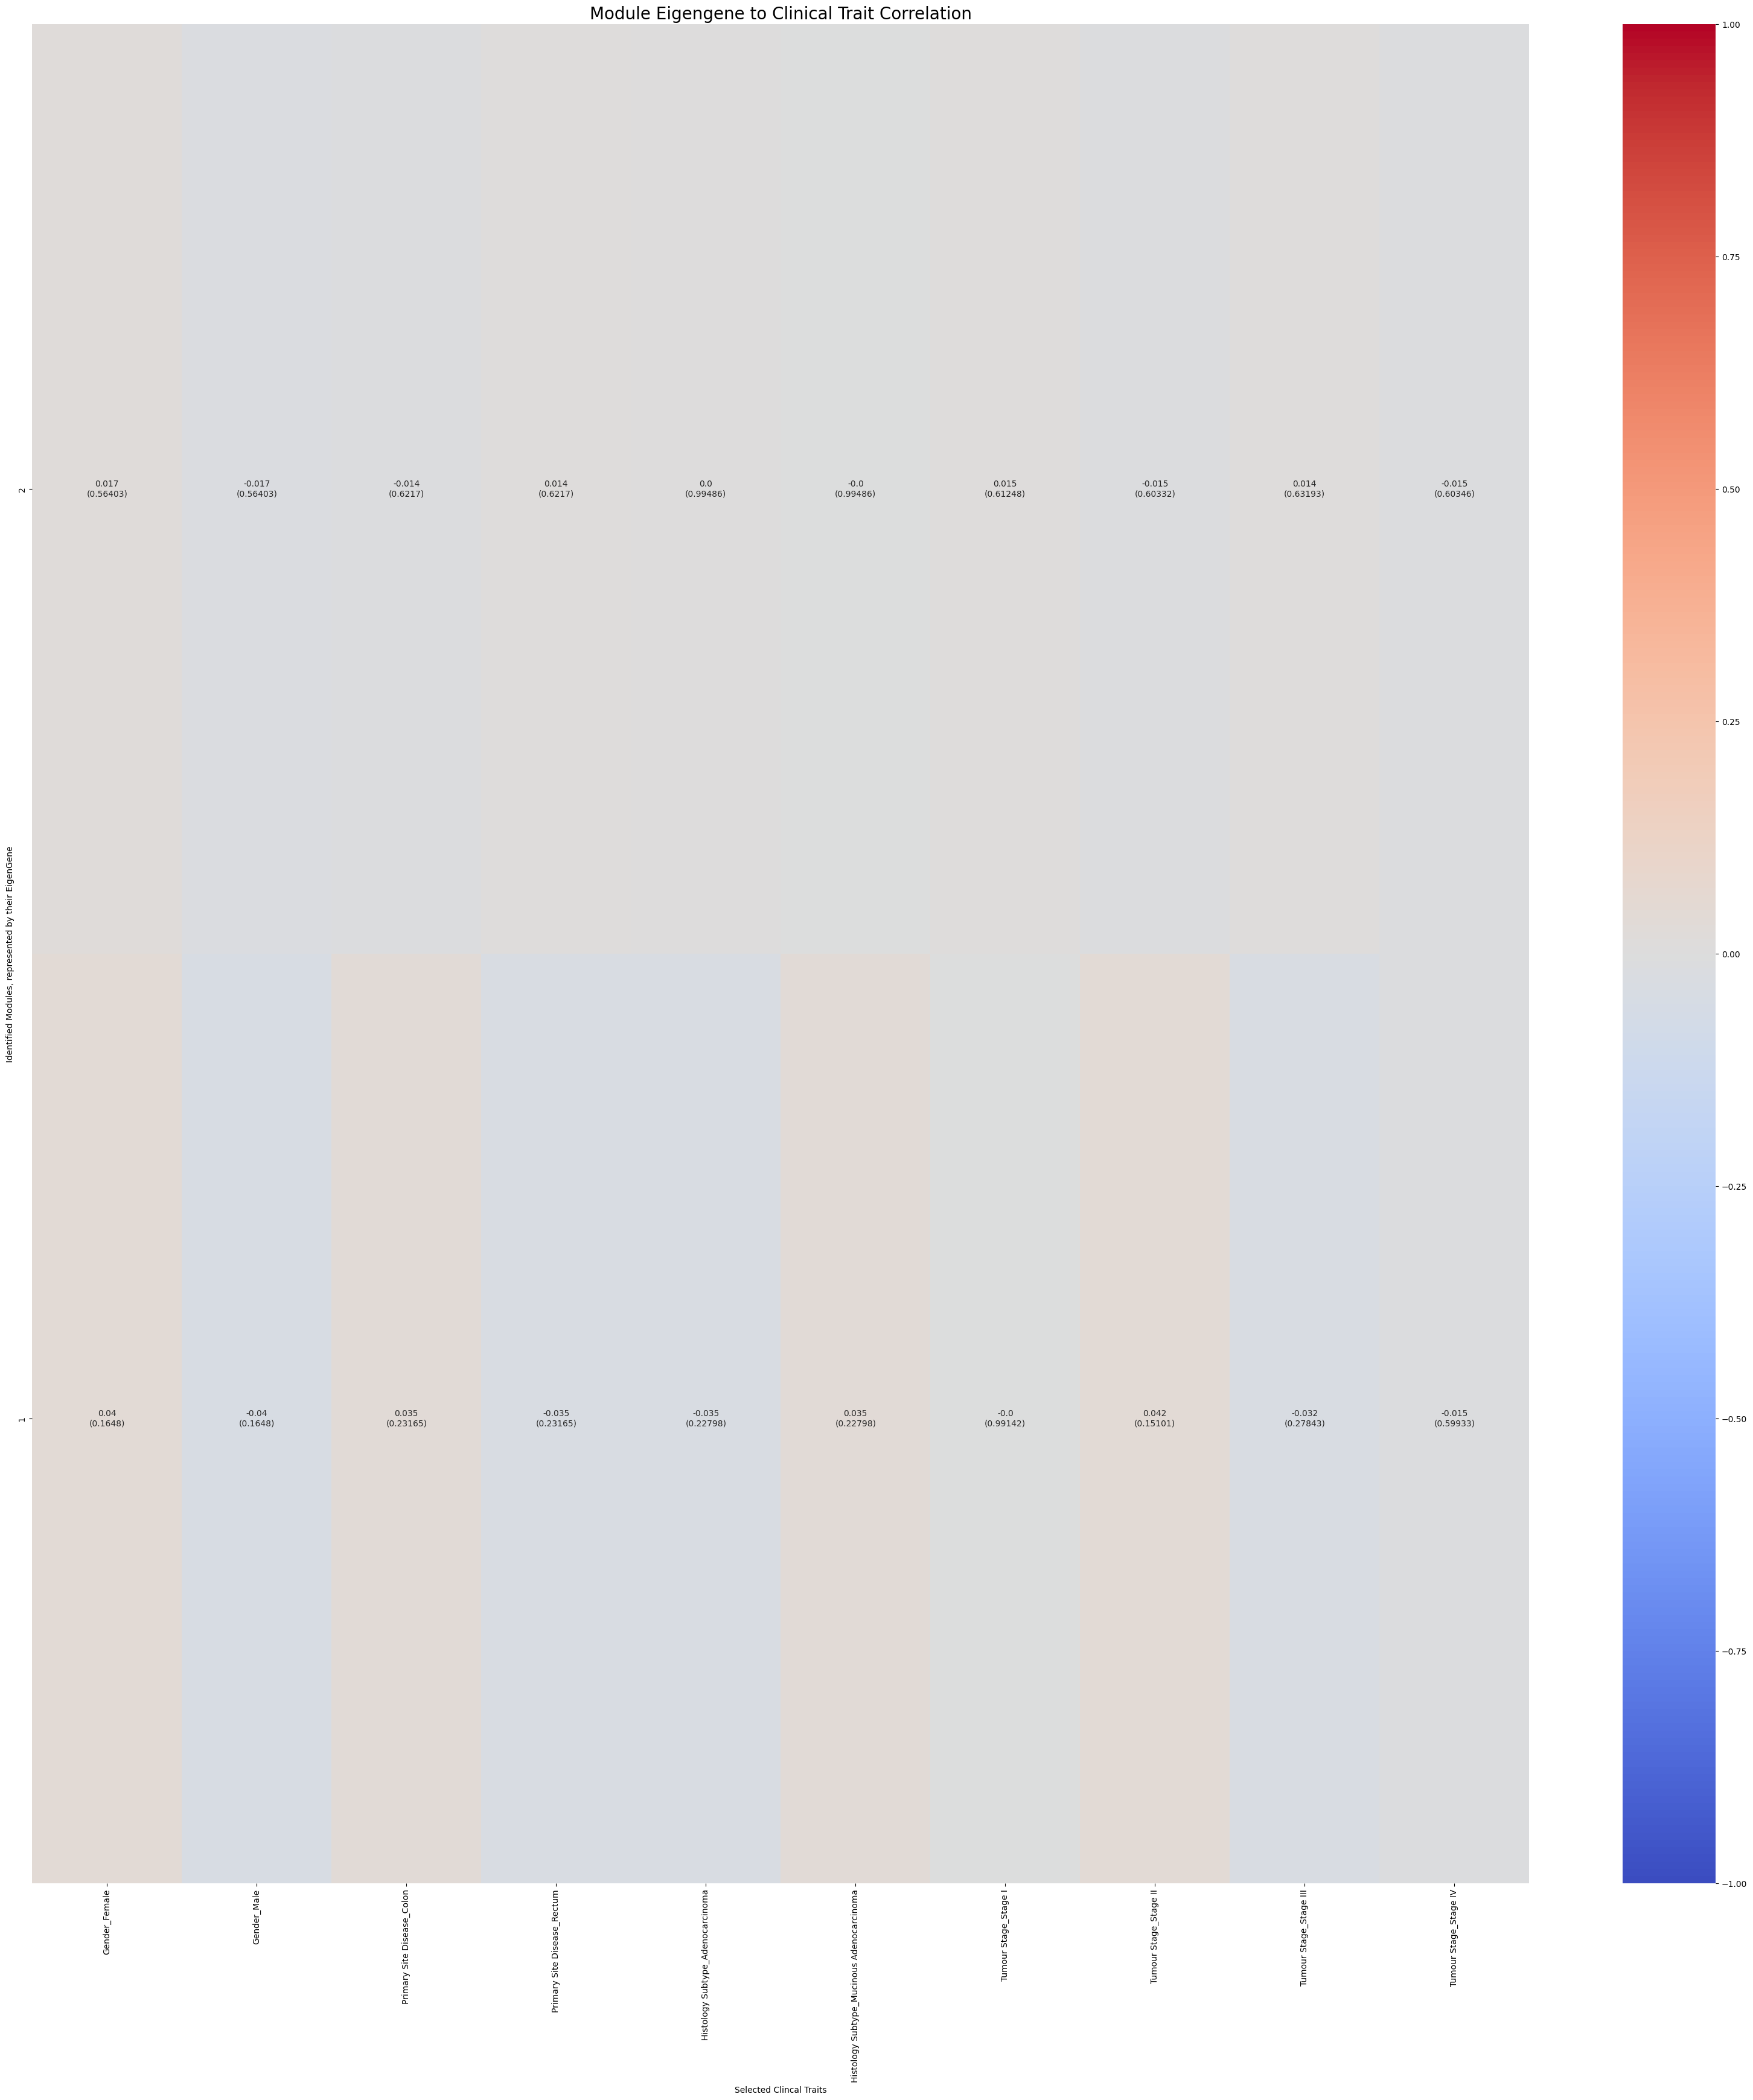

Done


In [13]:
# Run the Analysis, encoding the variables as categorical, and calculating correlation and p-value
trait_columns = list(trait_dataset.columns[1:] )
correlations, p_values = wgcnax.calculate_correlations(eigen_genes, trait_dataset, trait_columns)
print(f"{BOLD}{OKBLUE}Done\n\n{ENDC}")



## Plot the HEatmap
print(f"{BOLD}{OKBLUE}Plotting and Saving the Module EigenGene to Clinical Trait Correlation...{ENDC}")
title_figure = 'Module Eigengene to Clinical Trait Correlation'

annotations = correlations.round(3).astype(str) + '\n(' + p_values.round(5).astype(str) + ')'

plt.figure(figsize=(40, 40)) 
sns.heatmap(correlations, annot=annotations.values, fmt='', cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title(title_figure, fontsize=20)
plt.xlabel('Selected Clincal Traits', fontsize=10)
plt.ylabel('Identified Modules, represented by their EigenGene', fontsize=10)
plt.savefig(figures_dir + title_figure, dpi=150)
plt.show()
print(f"{BOLD}{OKBLUE}Done{ENDC}")